In [2]:
import tensorflow as tf

In [17]:
train=r"/home/teaching/Atmega_MIC/DP Students/Abhay/cropwise_data/banana"
training_set = tf.keras.utils.image_dataset_from_directory(
    train,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 751 files belonging to 4 classes.


In [18]:
classes = training_set.class_names
classes

['banana_cordana',
 'banana_healthy',
 'banana_pestalotiopsis',
 'banana_sigatoka']

In [19]:
total_batches = tf.data.experimental.cardinality(training_set).numpy()
train_size = int(0.8 * total_batches)
val_size = total_batches - train_size

In [20]:
train_dataset = training_set.take(train_size)
val_dataset = training_set.skip(train_size)
print(len(training_set))
print(len(train_dataset))
print(len(val_dataset))

47
37
10


In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # 6 classes
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


In [22]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras import Sequential

preprocessing = Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.1)
])

train_ds = train_dataset.map(lambda x, y: (preprocessing(x), y))
val_ds = val_dataset.map(lambda x, y: (x / 255.0, y))


In [23]:
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.4, patience=3, min_lr=1e-6)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=15,
                    callbacks=[early_stop, reduce_lr])


Epoch 1/15
37/37 [==============================] - 15s 333ms/step - loss: 0.6648 - categorical_accuracy: 0.7905 - val_loss: 0.1767 - val_categorical_accuracy: 0.9560 - lr: 0.0010
Epoch 2/15
37/37 [==============================] - 12s 298ms/step - loss: 0.1356 - categorical_accuracy: 0.9595 - val_loss: 0.0943 - val_categorical_accuracy: 0.9748 - lr: 0.0010
Epoch 3/15
37/37 [==============================] - 12s 297ms/step - loss: 0.0671 - categorical_accuracy: 0.9814 - val_loss: 0.0796 - val_categorical_accuracy: 0.9811 - lr: 0.0010
Epoch 4/15
37/37 [==============================] - 11s 285ms/step - loss: 0.0461 - categorical_accuracy: 0.9899 - val_loss: 0.0602 - val_categorical_accuracy: 0.9811 - lr: 0.0010
Epoch 5/15
37/37 [==============================] - 11s 281ms/step - loss: 0.0280 - categorical_accuracy: 0.9966 - val_loss: 0.0405 - val_categorical_accuracy: 0.9937 - lr: 0.0010
Epoch 6/15
37/37 [==============================] - 12s 293ms/step - loss: 0.0198 - categorical_accu

In [25]:
train_loss,train_acc = model.evaluate(train_ds)

37/37 [==============================] - 6s 151ms/step - loss: 0.0075 - categorical_accuracy: 0.9983


In [26]:
print(train_loss,train_acc)

0.007479710970073938 0.9983108043670654


In [27]:
val_loss,val_acc=model.evaluate(val_ds)

10/10 [==============================] - 5s 99ms/step - loss: 0.0073 - categorical_accuracy: 1.0000


In [28]:
print(val_loss,val_acc)

0.007317118812352419 1.0


In [40]:
model.save("trained_model_banana.keras")

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

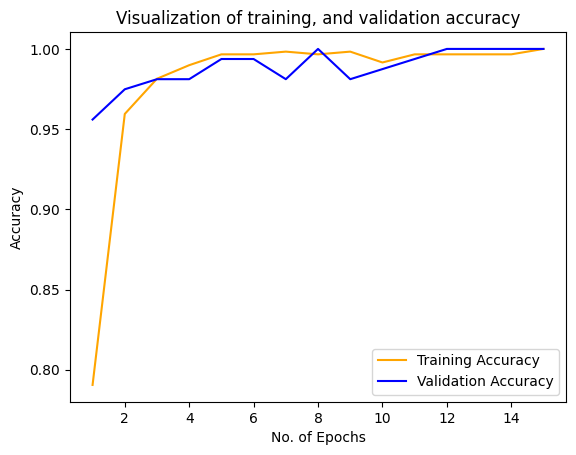

In [32]:
epochs=[i for i in range(1,16)]
plt.plot(epochs,history.history['categorical_accuracy'],color='orange',label='Training Accuracy')
plt.plot(epochs,history.history['val_categorical_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Visualization of training, and validation accuracy')
plt.legend()
plt.show()


In [37]:
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    predictions = model.predict(img_array)
    predicted_class = classes[np.argmax(predictions)]

    print(f"Predicted class: {predicted_class}")
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

In [38]:
from tensorflow.keras.preprocessing import image
import numpy as np

1/1 [==============================] - 1s 565ms/step
Predicted class: banana_sigatoka


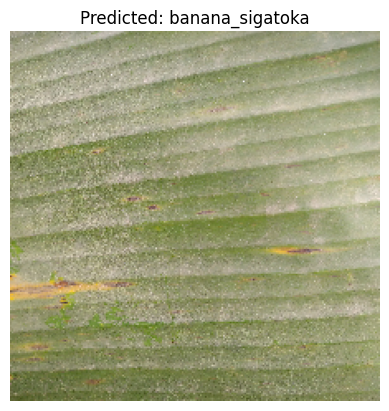

In [39]:
predict_image("/home/teaching/Atmega_MIC/DP Students/Abhay/cropwise_data/banana/banana_sigatoka/banana_IMG_20210311_102740_1.jpg")